/var/folders/m1/5dpmkc_567gddy0b98vly1w40000gn/T/ipykernel_24253/3331713133.py:72: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{short_prefix}_close_to_{long_prefix}_support'] = (short_close - long_support) / long_support
/var/folders/m1/5dpmkc_567gddy0b98vly1w40000gn/T/ipykernel_24253/3331713133.py:73: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{short_prefix}_close_to_{long_prefix}_resistance'] = (short_close - long_resistance) / long_resistance
/var/folders/m1/5dpmkc_567gddy0b98vly1w40000gn/T/ipykernel_24253/3331

[LightGBM] [Info] Number of positive: 326783, number of negative: 401512
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.220254 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 30434
[LightGBM] [Info] Number of data points in the train set: 728295, number of used features: 125
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.448696 -> initscore=-0.205941
[LightGBM] [Info] Start training from score -0.205941
Training until validation scores don't improve for 10 rounds
[100]	training's binary_error: 0.17819	valid_1's binary_error: 0.180301
[200]	training's binary_error: 0.163247	valid_1's binary_error: 0.16601
[300]	training's binary_error: 0.156459	valid_1's binary_error: 0.159987
[400]	training's binary_error: 0.152503	valid_1's binary_error: 0.15645
[500]	training's binary_error: 0.149731	valid_1's binary_error: 0.154487
[600]	train

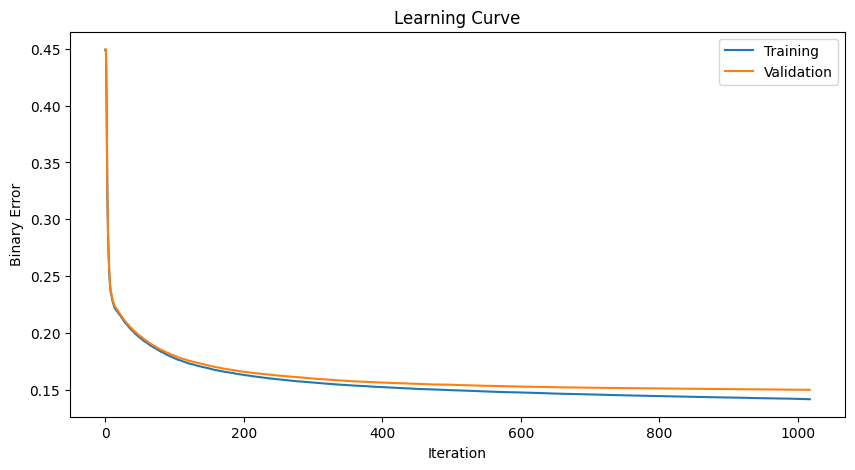

[LightGBM] [Info] Number of positive: 327433, number of negative: 400862
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.168122 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 30434
[LightGBM] [Info] Number of data points in the train set: 728295, number of used features: 125
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.449588 -> initscore=-0.202334
[LightGBM] [Info] Start training from score -0.202334
Training until validation scores don't improve for 10 rounds
[100]	training's binary_error: 0.177797	valid_1's binary_error: 0.180174
[200]	training's binary_error: 0.162913	valid_1's binary_error: 0.166538
[300]	training's binary_error: 0.156137	valid_1's binary_error: 0.160344
[400]	training's binary_error: 0.15191	valid_1's binary_error: 0.156769
[500]	training's binary_error: 0.149191	valid_1's binary_error: 0.154631
[600]	tra

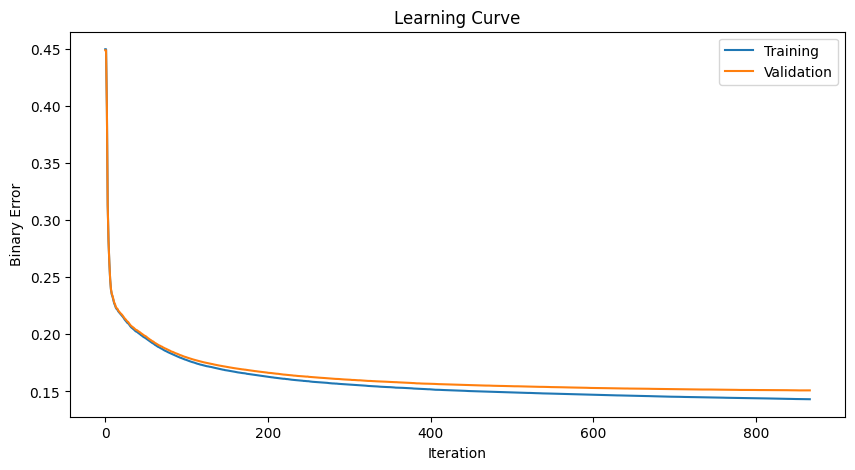

Mean accuracy: 0.8494936804454238


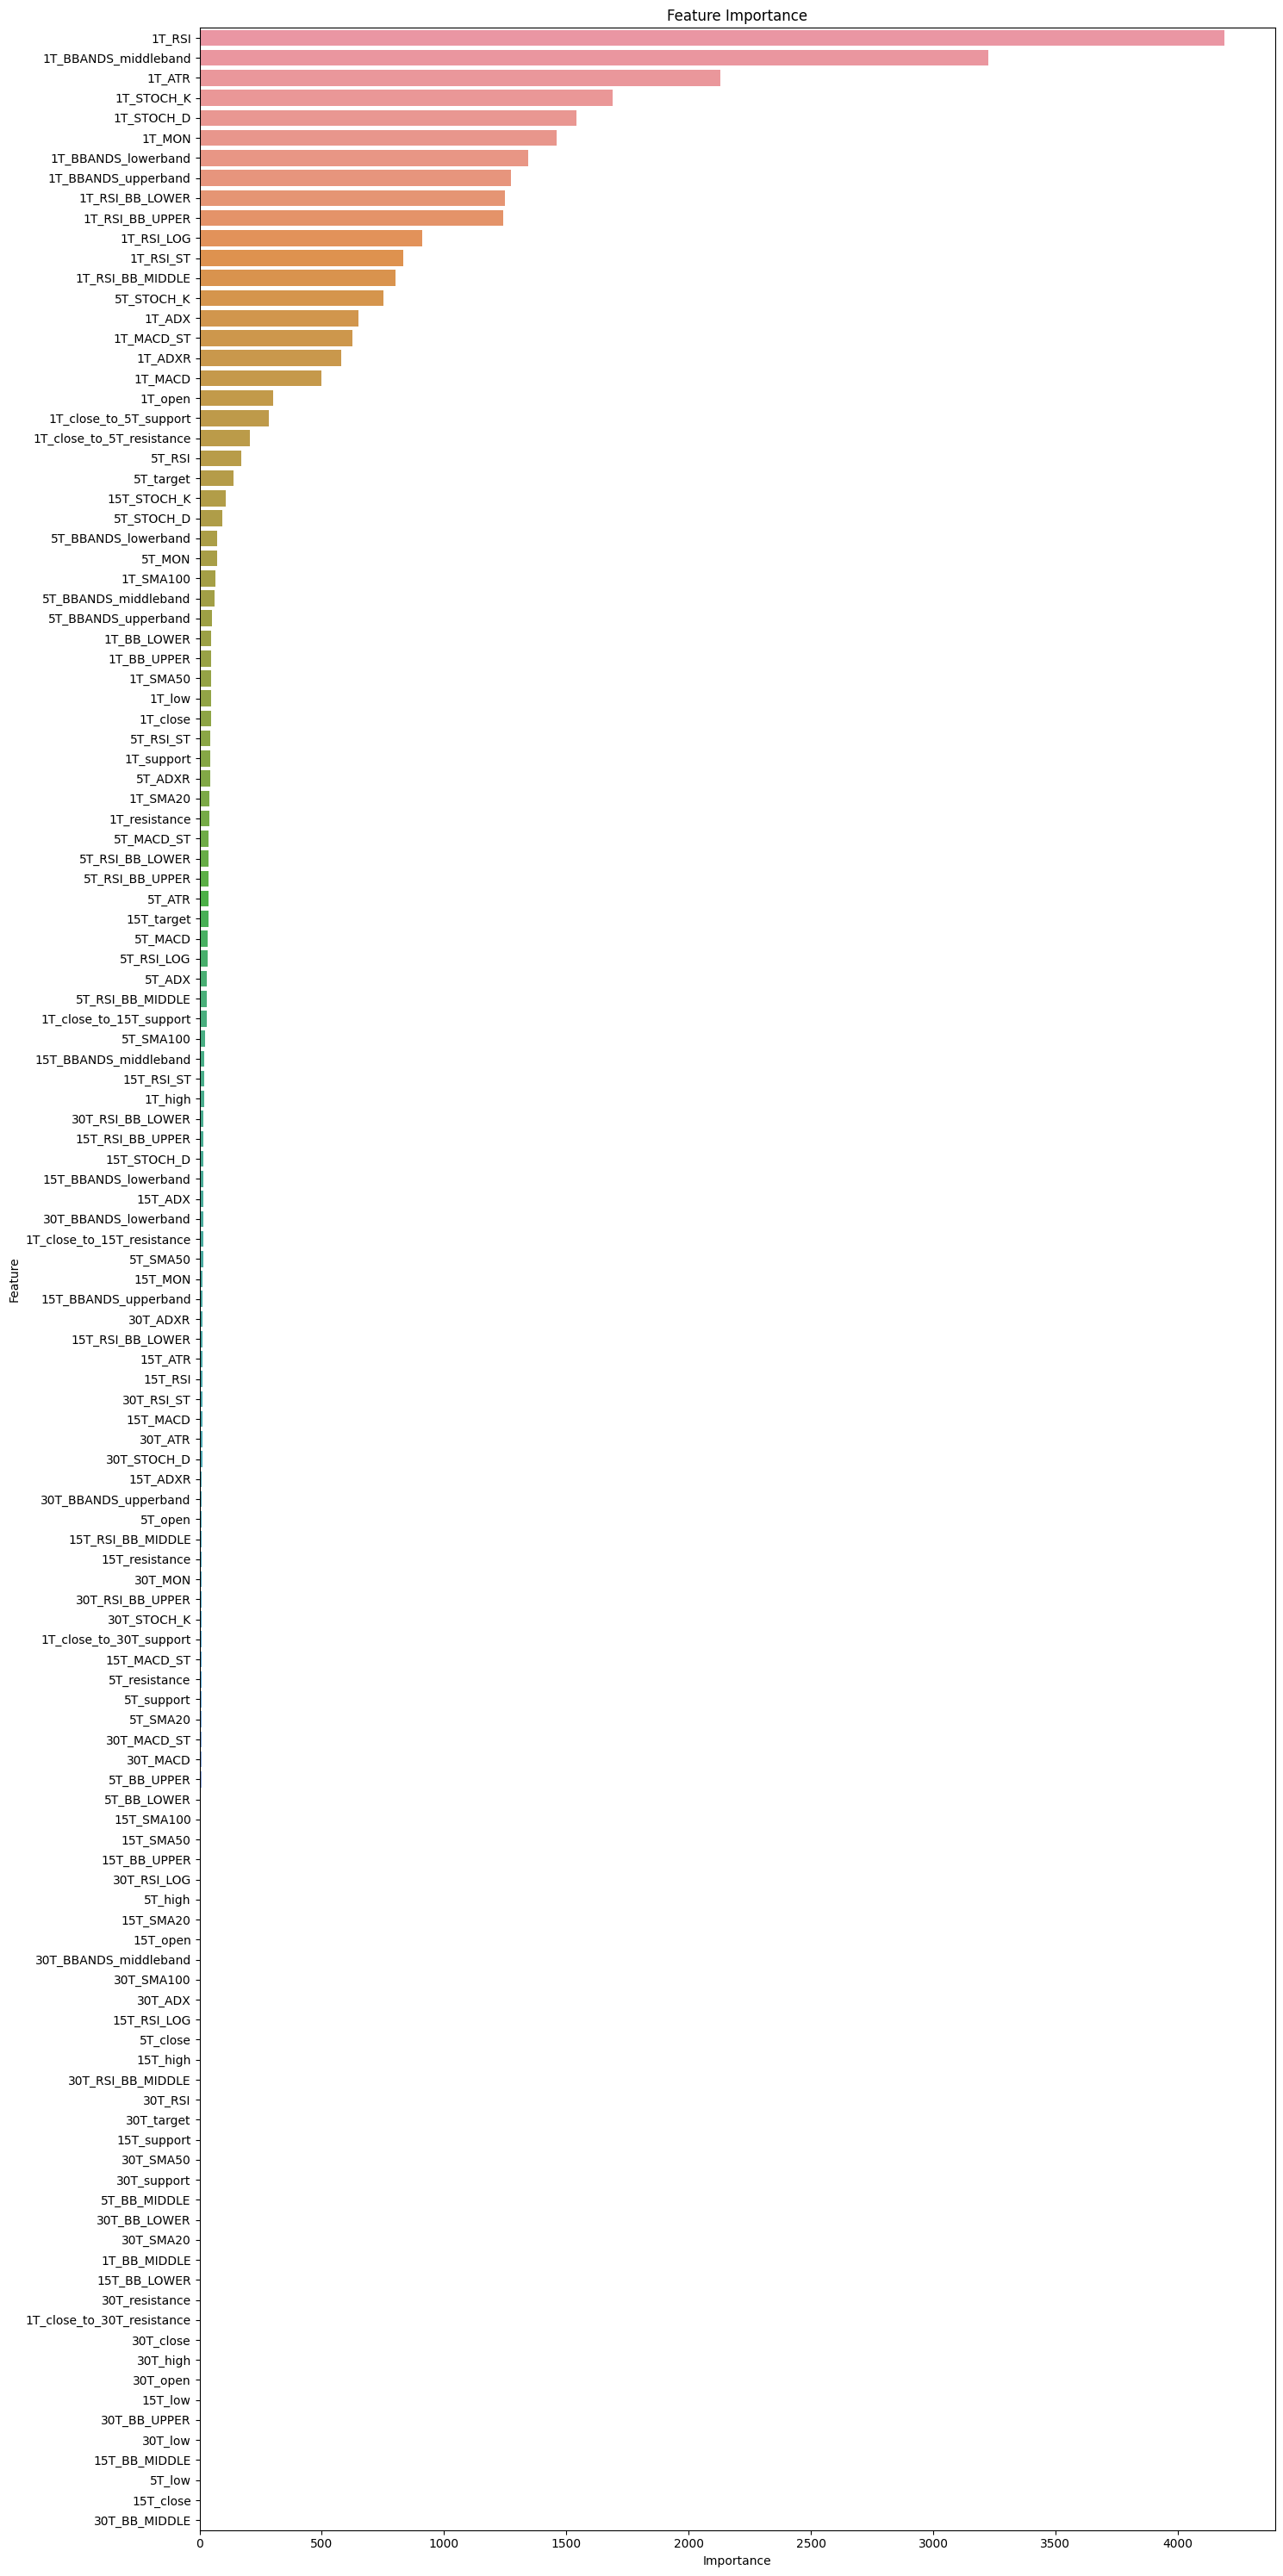

Model saved to model/1m_model.pkl


In [1]:
import os
import pandas as pd
import numpy as np
import talib
import lightgbm as lgb
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split, KFold
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from datetime import datetime, time, timedelta

pd.set_option('display.max_columns', None)

def load_data(file_names):
    dfs = []
    for file_name in file_names:
        df = pd.read_csv(file_name, index_col="date")
        dfs.append(df)
    return dfs

def feature_engineering(df, prefix):
    open = df[f'{prefix}_open'].values
    high = df[f'{prefix}_high'].values
    low = df[f'{prefix}_low'].values
    close = df[f'{prefix}_close'].values
    # volume = df[f'{prefix}_volume'].values
    hilo = (high + low) / 2

    rsi = talib.RSI(close, timeperiod=8) # default = 14
    df[f'{prefix}_RSI'] = rsi
    df[f'{prefix}_RSI_BB_UPPER'], df[f'{prefix}_RSI_BB_MIDDLE'], df[f'{prefix}_RSI_BB_LOWER'] = talib.BBANDS(rsi, timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)
    
    df[f'{prefix}_RSI_ST'] = talib.RSI(close)/close
    df[f'{prefix}_RSI_LOG'] = log_transform_feature(talib.RSI(close))
    df[f'{prefix}_MACD'], _, _ = talib.MACD(close)
    df[f'{prefix}_MACD_ST'], _, _ = talib.MACD(close)/close
    df[f'{prefix}_ATR'] = talib.ATR(high, low, close)
    df[f'{prefix}_ADX'] = talib.ADX(high, low, close, timeperiod=14)
    df[f'{prefix}_ADXR'] = talib.ADXR(high, low, close, timeperiod=14)
    
    df[f'{prefix}_SMA20'] = talib.SMA(close, timeperiod=20)
    df[f'{prefix}_SMA50'] = talib.SMA(close, timeperiod=50)
    df[f'{prefix}_SMA100'] = talib.SMA(close, timeperiod=100)
    
    df[f'{prefix}_BB_UPPER'], df[f'{prefix}_BB_MIDDLE'], df[f'{prefix}_BB_LOWER'] = talib.BBANDS(close, timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)
    df[f'{prefix}_BBANDS_upperband'] = (df[f'{prefix}_BB_UPPER'] - hilo) / close
    df[f'{prefix}_BBANDS_middleband'] = (df[f'{prefix}_BB_MIDDLE'] - hilo) / close
    df[f'{prefix}_BBANDS_lowerband'] = (df[f'{prefix}_BB_LOWER'] - hilo) / close
    # df[f'{prefix}_BBANDS_bandwidth'] = (df[f'{prefix}_BB_UPPER'] - df[f'{prefix}_BB_LOWER']) / df[f'{prefix}_BB_MIDDLE']
    # df[f'{prefix}_BBANDS_squeeze'] = (df[f'{prefix}_BBANDS_bandwidth'] < df[f'{prefix}_BBANDS_bandwidth'].rolling(window=20).mean()).astype(int)

    df[f'{prefix}_STOCH_K'], df[f'{prefix}_STOCH_D'] = talib.STOCH(high, low, close)/close
    df[f'{prefix}_MON'] = talib.MOM(close, timeperiod=5)
    # df[f'{prefix}_OBV'] = talib.OBV(close, volume)

    df[f'{prefix}_support'] = df[f'{prefix}_low'].rolling(window=20, min_periods=1).min()
    df[f'{prefix}_resistance'] = df[f'{prefix}_high'].rolling(window=20, min_periods=1).max()

    df = df.fillna(method='ffill')

    return df

def log_transform_feature(X):
    X[X <= 0] = np.finfo(float).eps
    return np.log(X)

def price_relation(df, short_prefix, long_prefix):
    short_close = df[f'{short_prefix}_close']
    long_support = df[f'{long_prefix}_support']
    long_resistance = df[f'{long_prefix}_resistance']
    df[f'{short_prefix}_close_to_{long_prefix}_support'] = (short_close - long_support) / long_support
    df[f'{short_prefix}_close_to_{long_prefix}_resistance'] = (short_close - long_resistance) / long_resistance
    return df

def create_label(df, prefix, lookbehind=1):
    df[f'{prefix}_target'] = (df[f'{prefix}_close'] > df[f'{prefix}_close'].shift(lookbehind)).astype(int)
    df = df.fillna(method='ffill')
    return df

def plot_learning_curve(evals_result):
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    ax.plot(np.arange(len(evals_result['training']['binary_error'])),
            evals_result['training']['binary_error'], label='Training')
    ax.plot(np.arange(len(evals_result['valid_1']['binary_error'])),
            evals_result['valid_1']['binary_error'], label='Validation')
    ax.set_title('Learning Curve')
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Binary Error')
    ax.legend()
    plt.show()

def plot_feature_importance(importances, feature_names):
    importance = pd.DataFrame({"Feature": feature_names,
                               "Importance": importances})
    importance.sort_values(by="Importance", ascending=False, inplace=True)
    plt.figure(figsize=(15, 30))
    sns.barplot(x="Importance", y="Feature", data=importance)
    plt.title("Feature Importance")
    plt.tight_layout()
    plt.show()

def train_and_evaluate(df, n_splits=2):
    features = df.drop('1T_target', axis=1)
    labels = df['1T_target']

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    accuracies = []
    feature_importances = []

    for train_index, test_index in kf.split(features):
        X_train, X_test = features.iloc[train_index], features.iloc[test_index]
        y_train, y_test = labels.iloc[train_index], labels.iloc[test_index]

        train_data = lgb.Dataset(X_train, label=y_train)
        test_data = lgb.Dataset(X_test, label=y_test)

        params = {
            'objective': 'binary',
            'metric': 'binary_error',
            'num_leaves': 31,
            'learning_rate': 0.05,
            'feature_fraction': 0.9
        }

        evals_result = {}

        model = lgb.train(
            params=params,
            train_set=train_data,
            valid_sets=[train_data, test_data],
            num_boost_round=10000,
            callbacks=[
                lgb.callback.early_stopping(10),
                lgb.callback.log_evaluation(period=100),
                lgb.callback.record_evaluation(evals_result)
            ],
        )

        y_pred = model.predict(X_test)
        y_pred = np.round(y_pred).astype(int)

        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)
        print(f"Accuracy: {accuracy}")
        print(classification_report(y_test, y_pred))
        
        plot_learning_curve(evals_result)
        feature_importances.append(model.feature_importance())
    
    mean_accuracy = np.mean(accuracies)
    print(f"Mean accuracy: {mean_accuracy}")

    mean_importance = np.mean(feature_importances, axis=0)
    plot_feature_importance(mean_importance, features.columns)

    return model, evals_result

def resample_data(df):    
    # Convert the index to datetime
    df.index = pd.to_datetime(df.index)

    # Resample data to different timeframes
    timeframes = ['1T', '5T', '15T', '30T']

    resampled_dfs = []

    for tf in timeframes:
        resampled = df.resample(tf).agg({'open': 'first', 'high': 'max', 'low': 'min', 'close': 'last'})
        resampled.dropna(inplace=True)
        resampled.columns = [f"{tf}_{col}" for col in resampled.columns]
        prefix = resampled.columns[0].split('_')[0]
        processed_df = feature_engineering(resampled, prefix)
        processed_df = create_label(processed_df, prefix)
        resampled_dfs.append(processed_df)

    # Combine resampled data
    combined_resampled = pd.concat(resampled_dfs, axis=1).fillna(0)
    return combined_resampled

if __name__ == "__main__":
    file_names = ["combined_data.csv"]
    dfs = load_data(file_names)

    # Assuming you have only one DataFrame in the list
    combined_df = dfs[0]
    combined_df = resample_data(combined_df)

    # add feature support and resistance
    combined_df = price_relation(combined_df, '1T', '5T')
    combined_df = price_relation(combined_df, '1T', '15T')
    combined_df = price_relation(combined_df, '1T', '30T')

    model, evals_result = train_and_evaluate(combined_df)

    model_path = os.path.join("model", "1m_model.pkl")
    with open(model_path, "wb") as f:
        pickle.dump(model, f)

    print(f"Model saved to {model_path}")